## Assignment: predicting house prices

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels

import statsmodels.api as sm
from math import ceil


import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
house_prices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
# this dataset has a huge number of columns
house_prices.shape

(1460, 81)

In [5]:
# examine for null values
# it doesn't seem as if any of the
# features that interest me have any
house_prices.isnull().sum().head()

id               0
mssubclass       0
mszoning         0
lotfrontage    259
lotarea          0
dtype: int64

In [6]:
house_prices.bldgtype.value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: bldgtype, dtype: int64

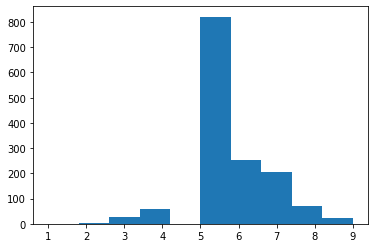

In [7]:
plt.hist(house_prices.overallcond);

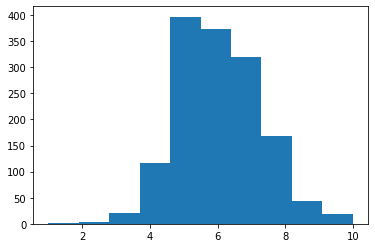

In [8]:
plt.hist(house_prices.overallqual);

In [9]:
house_prices.bedroomabvgr.value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: bedroomabvgr, dtype: int64

#### Features that seem the most important to me:
1. overal quality
1. overal condition
1. number of bedrooms
1. neighborhood
1. GrLivArea: Above grade (ground) living area square feet
 - although there might be a lot of colinearity between this and number of bedrooms


    SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
    MSSubClass: The building class
    MSZoning: The general zoning classification
    LotFrontage: Linear feet of street connected to property
    LotArea: Lot size in square feet
    Street: Type of road access
    Alley: Type of alley access
    LotShape: General shape of property
    LandContour: Flatness of the property
    Utilities: Type of utilities available
    LotConfig: Lot configuration
    LandSlope: Slope of property
        Neighborhood: Physical locations within Ames city limits
    Condition1: Proximity to main road or railroad
    Condition2: Proximity to main road or railroad (if a second is present)
    BldgType: Type of dwelling
    HouseStyle: Style of dwelling
        OverallQual: Overall material and finish quality
        OverallCond: Overall condition rating
    YearBuilt: Original construction date
    YearRemodAdd: Remodel date
    RoofStyle: Type of roof
    RoofMatl: Roof material
    Exterior1st: Exterior covering on house
    Exterior2nd: Exterior covering on house (if more than one material)
    MasVnrType: Masonry veneer type
    MasVnrArea: Masonry veneer area in square feet
    ExterQual: Exterior material quality
    ExterCond: Present condition of the material on the exterior
    Foundation: Type of foundation
    BsmtQual: Height of the basement
    BsmtCond: General condition of the basement
    BsmtExposure: Walkout or garden level basement walls
    BsmtFinType1: Quality of basement finished area
    BsmtFinSF1: Type 1 finished square feet
    BsmtFinType2: Quality of second finished area (if present)
    BsmtFinSF2: Type 2 finished square feet
    BsmtUnfSF: Unfinished square feet of basement area
    TotalBsmtSF: Total square feet of basement area
    Heating: Type of heating
    HeatingQC: Heating quality and condition
    CentralAir: Central air conditioning
    Electrical: Electrical system
    1stFlrSF: First Floor square feet
    2ndFlrSF: Second floor square feet
    LowQualFinSF: Low quality finished square feet (all floors)
        GrLivArea: Above grade (ground) living area square feet
    BsmtFullBath: Basement full bathrooms
    BsmtHalfBath: Basement half bathrooms
    FullBath: Full bathrooms above grade
    HalfBath: Half baths above grade
        Bedroom: Number of bedrooms above basement level
    Kitchen: Number of kitchens
    KitchenQual: Kitchen quality
    TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    Functional: Home functionality rating
    Fireplaces: Number of fireplaces
    FireplaceQu: Fireplace quality
    GarageType: Garage location
    GarageYrBlt: Year garage was built
    GarageFinish: Interior finish of the garage
    GarageCars: Size of garage in car capacity
    GarageArea: Size of garage in square feet
    GarageQual: Garage quality
    GarageCond: Garage condition
    PavedDrive: Paved driveway
    WoodDeckSF: Wood deck area in square feet
    OpenPorchSF: Open porch area in square feet
    EnclosedPorch: Enclosed porch area in square feet
    3SsnPorch: Three season porch area in square feet
    ScreenPorch: Screen porch area in square feet
    PoolArea: Pool area in square feet
    PoolQC: Pool quality
    Fence: Fence quality
    MiscFeature: Miscellaneous feature not covered in other categories
    MiscVal: Value of miscellaneous feature
    MoSold: Month Sold
    YrSold: Year Sold
    SaleType: Type of sale
    SaleCondition: Condition of sale

In [10]:
# numerical features I'm interested in
house_features = house_prices[[x.lower() for x in ['OverallQual',
                                                    'OverallCond', 
                                                    'GrLivArea',
                                                    'bedroomabvgr'
                                                    ]]].copy()

In [11]:
# combine numerical columns above with 
# categorical feature neighborhood converted to numerical
pd.concat([house_features, pd.get_dummies(house_prices.neighborhood)], axis=1).head()

,overallqual,overallcond,grlivarea,bedroomabvgr,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,7,5,1710,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,8,1262,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,7,5,1786,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,5,1717,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,5,2198,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [12]:
# create scatter plots
# contrasting each attribute against target

fig = plt.figure(figsize=(15, 45))

for i, column in enumerate(X.columns):
    plt.subplot(ceil(len(X.columns)/3), 3, i+1)
    plt.title(column)
    plt.scatter(Y, X[column], color='brown', alpha=.03);

NameError: name 'X' is not defined

<Figure size 1080x3240 with 0 Axes>

### Model Fitting

In [ ]:
# using sklearn
# Y is the target variable
Y = house_prices.saleprice
# X is the feature set which includes
# is_male and is_smoker variables
X = pd.concat([house_features, pd.get_dummies(house_prices.neighborhood)], axis=1)

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

In [ ]:
# using statsmodel

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

## Gauss Markov Conditions to consider:

* linearity of models in their coefficients
* the error term should be zero on average
* homoscedasticity
* low multicollinearity
* error terms should be uncorrelated with one another
* features shouldn't be correlated with the errors
* normality of the errors


#### 1. linearity of models in their coefficients

In principle, this assumption is not related to estimation but to how we specify our model. So as long as we use models that take into account this linearity assumption as we did in our medical costs example, then we shouldn't worry about this assumption at all.

<font color=red>But how would I test for this?</font>

Re Dustin - This is more of a visualization thing.

#### 2. the error term should be zero on average


In [ ]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Since I have included the constant term in the model, the average of the model's error is effectively zero.

#### 3. homoscedasticity - the distribution of its error terms (known as "scedasticity") is consistent for all predicted values

In [ ]:
plt.scatter(predictions, errors, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Visually, it appears to not be homoscedastic.

In [ ]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

<font color=red> Some fixes to heteroscedasticity include transforming the dependent variable (see [Box Cox transformation](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) and [log transformation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/)) and adding features that target the poorly-estimated areas.</font>

#### 4. low multicollinearity

In [ ]:
# check to see how correlated the features I have selected are
X.corr().iloc[:,1].sort_values(ascending=False)

In [ ]:
# compare features using a heatmap
plt.figure(figsize=(15, 15))

ax = sns.heatmap(X.corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, annot=True, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

It doesn't seem that many of them are very correlated, especially not neighborhoods.

#### 5. error terms should be uncorrelated with one another


In [ ]:
# what are the y and x axis here?
plt.plot(errors)

In [ ]:
# check using autocorrelation function from statsmodels

from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])

It appears autocorrelation between the errors of my housing prices model is very low.

Dustin - also recommended the Durbin-Watson test to check for this
https://www.statisticshowto.datasciencecentral.com/durbin-watson-test-coefficient/

#### 6. features shouldn't be correlated with the errors


Arguably the most important assumption: explanatory variables and errors should be independent. If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased. This assumption is known as the **exogeneity**.

Violations of the exogeneity assumption may have several sources. Common causes are omitted variables and simultaneous causation between independent variables and the target. If the problem stems from simultaneous causation then we need to apply some advanced techniques to solve for the issue but this is beyond the scope of this bootcamp.

#### 7. normality of the errors

In [ ]:
# check for the normality of the errors
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()

The errors seems to be roughly normal, but not perfectly normal through visual inspection.

Dustin recommends running QQ plot from statsmodels

In [ ]:
# check for normality using statistical tests

from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

The super small p-value result from each of these tests indicate that my errors are not normally distributed.

## Interpreting House Prices Model Results

1. Which features are statistically significant, and which are not?
1. Now, exclude the insignificant features from your model. Did anything change?
1. Interpret the statistically significant coefficients by quantifying their relations with the house prices. Which features have a more prominent effect on house prices?
1. Do the results sound reasonable to you? If not, try to explain the potential reasons.

### 1. Which features are statistically significant, and which are not?

In [ ]:
original_pvalues = results.pvalues

In [ ]:
round(original_pvalues, 2)

In [ ]:
# identify features with p-values 
# indicating that the feature is significant
# 'results' is an output from statsmodels above

results.pvalues[round(results.pvalues, 2) > .1].index

### 2. Now, exclude the insignificant features from your model. Did anything change?

In [ ]:
house_features.head()

In [ ]:
neighborhood_features = pd.get_dummies(house_prices.neighborhood)

In [ ]:
neighborhood_features.head()

In [ ]:
# original columns
neighborhood_features.shape

In [ ]:
# drop columns identified as not statistically significant
neighborhood_features.drop(results.pvalues[round(results.pvalues, 2) > .1].index, axis=1, inplace=True)

In [ ]:
# verify that columns have been removed
neighborhood_features.shape

In [ ]:
# drop columns that aren't statistically significant
results.pvalues[round(results.pvalues, 2) > .1].index

In [ ]:
# Y is the target variable
Y = house_prices.saleprice

# X is the feature
X = pd.concat([house_features, neighborhood_features], axis=1)

In [ ]:
# using statsmodel

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

### Results:
1. Adjusted R-squared has increased only slight in values, meaning the fit is slightly better after excluding some of the neighborhoods.
1. Several of the features that were zero before are now above the 10% threshold

### 3. Interpret the statistically significant coefficients by quantifying their relations with the house prices. Which features have a more prominent effect on house prices?


In [ ]:
results.params.sort_values(ascending=False)

### 4. Do the results sound reasonable to you? If not, try to explain the potential reasons.

1. The top 5 coefficients are neighborhoods, followed by categorical variable "overallqual".  I would have thought overallqual would be higher on the list.
1. In addition to neighborhoods positively correlated with the target variable, a number of the neighborhoods are negatively correlated with the target variable.  

##  Evaluating Performance - House prices model

In this exercise, you'll work on your house prices model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Run your house prices model again and assess the goodness of fit of your model using F-test, R-squared, adjusted R-squared, AIC and BIC.
 - Done, see above.
1. Do you think your model is satisfactory? If so, why?
 - my model explaines almost 80% of the variance in the data, or put another way - 80% of the variance in the outcome variable is explained by the explanatory variables in the model.
1. In order to improve the goodness of fit of your model, try different model specifications by adding or removing some variables. 
 - after excluding 7 neighborhoods that weren't statistically significant, the R-square values increased only slightly from 0.792 to 0.793.
 - after excluding all neighborhoods - R-squared dropped to 0.724
 - after exploring with other features('garagearea','fireplaces','yearbuilt','lotarea'), the model performance dropped to R-squared = 0.557

1. For each model you try, get the goodness of fit metrics and compare your models with each other. Which model is the best and why?
 - my first model (using a combination of continuous features and categorical features) excluding the categorical features that weren't statistically significant has performed the best. I think this model is successful since I spent the time to carefully think through each feature, only including those that I felt would communicate the most information about the homes value.  

### Adjusted Model - Excluding all neighborhoods, including continuous features I was originally using

In [15]:
# Y is the target variable
Y = house_prices.saleprice

# X is the feature
# includ only continuous features
# none of the neighborhoods
X = pd.concat([house_features])

In [16]:
# using statsmodel

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     956.8
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:07:05   Log-Likelihood:                -17603.
No. Observations:                1460   AIC:                         3.522e+04
Df Residuals:                    1455   BIC:                         3.524e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.949e+04   8533.572     -9.315      0.000   -9.62e+04   -6.28e+04
overallqual   3.058e+04   1030.350     29.683      0.000    2.86e+04    3.26e+04
overallcond    663.0282    988.138      0.671      0.502   -1275.300    2601.356
grlivarea       69.3821      3.163     21.932      0.000      63.177      75.588
bedroomabvgr  -1.22e+04   1648.949     -7.398      0.000   -1.54e+04   -8964.615
==============================================================================
Omnibus:                      329.524   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13946.276
Skew:                          -0.007   Prob(JB):                         0.00
Kurtosis:                      18.141   Cond. No.                     1.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Results:
1. Adjusted R-squared has increased only slight in values, meaning the fit is slightly better after excluding some of the neighborhoods.
1. Several of the features that were zero before are now above the 10% threshold

In [17]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [25]:
house_prices.head(3)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500


In [26]:
house_prices.loc[:,['garagearea','fireplaces','yearbuilt','lotarea']]

,garagearea,fireplaces,yearbuilt,lotarea
0,548,0,2003,8450
1,460,1,1976,9600
2,608,1,2001,11250
3,642,1,1915,9550
4,836,1,2000,14260
...,...,...,...,...
1455,460,1,1999,7917
1456,500,2,1978,13175
1457,252,2,1941,9042
1458,240,0,1950,9717


In [30]:
# verify no NaNs
house_prices.loc[:,['garagearea','fireplaces','yearbuilt','lotarea']].isna().sum()

garagearea    0
fireplaces    0
yearbuilt     0
lotarea       0
dtype: int64

### Adjusted Model - Including 4 random continuous features

In [31]:
# Y is the target variable
Y = house_prices.saleprice

# X is the feature
# includ only continuous features
# none of the neighborhoods
X = house_prices.loc[:,['garagearea','fireplaces','yearbuilt','lotarea']]

In [32]:
# using statsmodel

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     459.7
Date:                Tue, 12 Nov 2019   Prob (F-statistic):          2.82e-256
Time:                        16:17:16   Log-Likelihood:                -17948.
No. Observations:                1460   AIC:                         3.591e+04
Df Residuals:                    1455   BIC:                         3.593e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.445e+06   1.02e+05    -14.189      0.000   -1.64e+06   -1.24e+06
garagearea   142.7828      7.656     18.650      0.000     127.765     157.801
fireplaces   3.57e+04   2295.888     15.549      0.000    3.12e+04    4.02e+04
yearbuilt    774.5331     52.439     14.770      0.000     671.668     877.398
lotarea        0.8892      0.146      6.104      0.000       0.603       1.175
==============================================================================
Omnibus:                      694.292   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9146.108
Skew:                           1.870   Prob(JB):                         0.00
Kurtosis:                      14.677   Cond. No.                     1.07e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### To consider further - experiment with strictly categorical features, use sklearn's tool to do the encoding.